In [1]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report, accuracy_score, f1_score
import torch.nn.functional as F
import torch
import os
from tqdm import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import json
import random
import logging
import re
from torch.optim import Adam
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

In [2]:
data_file_address = 'C:\\Users\\markn\\Kaggle\\resumeNER\\Entity Recognition in Resumes.json'

In [3]:
df_data = pd.read_json(data_file_address, lines=True)
df_data.head(10)

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN
5,Anvitha Rao\nAutomation developer\n\n- Email m...,"[{'label': ['Skills'], 'points': [{'start': 28...",NaN
6,arjun ks\nSenior Program coordinator - oracle ...,"[{'label': ['Skills'], 'points': [{'start': 34...",NaN
7,"Arun Elumalai\nQA Tester\n\nChennai, Tamil Nad...","[{'label': ['Skills'], 'points': [{'start': 19...",NaN
8,Ashalata Bisoyi\nTransaction Processor - Oracl...,"[{'label': ['Skills'], 'points': [{'start': 17...",NaN
9,Ashok Kunam\nTeam Lead - Microsoft\n\n- Email ...,"[{'label': ['Skills'], 'points': [{'start': 41...",NaN


In [4]:
for i in range(len(df_data)):
    df_data['content'][i] = df_data['content'][i].replace('\n', ' ')
df_data.head()

C:\Users\markn\AppData\Local\Temp\ipykernel_16520\148732144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['content'][i] = df_data['content'][i].replace('\n', ' ')


,content,annotation,extras
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [5]:
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r', encoding='utf8') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data

In [6]:
data = trim_entity_spans(convert_dataturks_to_spacy(data_file_address))
data[0]

["Abhishek Jha Application Development Associate - Accenture  Bengaluru, Karnataka - Email me on Indeed: indeed.com/r/Abhishek-Jha/10e7a8cb732bc43a  • To work for an organization which provides me the opportunity to improve my skills and knowledge for my individual and company's growth in best possible ways.  Willing to relocate to: Bangalore, Karnataka  WORK EXPERIENCE  Application Development Associate  Accenture -  November 2017 to Present  Role: Currently working on Chat-bot. Developing Backend Oracle PeopleSoft Queries for the Bot which will be triggered based on given input. Also, Training the bot for different possible utterances (Both positive and negative), which will be given as input by the user.  EDUCATION  B.E in Information science and engineering  B.v.b college of engineering and technology -  Hubli, Karnataka  August 2013 to June 2017  12th in Mathematics  Woodbine modern school  April 2011 to March 2013  10th  Kendriya Vidyalaya  April 2001 to March 2011  SKILLS  C (Le

In [7]:
# Changing data to appropriate format so as to feed it to the model
from tqdm import tqdm_notebook as tqdm
cleanedDF = pd.DataFrame(columns=["setences_cleaned"])
sum1 = 0
for i in tqdm(range(len(data))):
    start = 0
    emptyList = ["Empty"] * len(data[i][0].split())
    numberOfWords = 0
    lenOfString = len(data[i][0])
    strData = data[i][0]
    strDictData = data[i][1]
    lastIndexOfSpace = strData.rfind(' ')
    for i in range(lenOfString):
        if (strData[i]==" " and strData[i+1]!=" "):
            for k,v in strDictData.items():
                for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (start>=int(entList[0]) and i<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        break
                    else:
                        continue
            start = i + 1  
            numberOfWords += 1
        if (i == lastIndexOfSpace):
            for j in range(len(v)):
                    entList = v[len(v)-j-1]
                    if (lastIndexOfSpace>=int(entList[0]) and lenOfString<=int(entList[1])):
                        emptyList[numberOfWords] = entList[2]
                        numberOfWords += 1
    cleanedDF = cleanedDF.append(pd.Series([emptyList],  index=cleanedDF.columns ), ignore_index=True )
    sum1 = sum1 + numberOfWords

C:\Users\markn\AppData\Local\Temp\ipykernel_16520\2042847216.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(data))):


  0%|          | 0/220 [00:00<?, ?it/s]

C:\Users\markn\AppData\Local\Temp\ipykernel_16520\2042847216.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleanedDF = cleanedDF.append(pd.Series([emptyList],  index=cleanedDF.columns ), ignore_index=True )
C:\Users\markn\AppData\Local\Temp\ipykernel_16520\2042847216.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleanedDF = cleanedDF.append(pd.Series([emptyList],  index=cleanedDF.columns ), ignore_index=True )
C:\Users\markn\AppData\Local\Temp\ipykernel_16520\2042847216.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cleanedDF = cleanedDF.append(pd.Series([emptyList],  index=cleanedDF.columns ), ignore_index=True )
C:\Users\markn\AppData\Local\Temp\ipykernel_16520\2042847216.py:31: FutureWarning: The fram

In [8]:
cleanedDF.head()

,setences_cleaned
0,"[Name, Name, Designation, Designation, Designa..."
1,"[Name, Name, Empty, Empty, Empty, Empty, Empty..."
2,"[Name, Name, Name, Empty, Empty, Empty, Empty,..."
3,"[Name, Name, Designation, Designation, Designa..."
4,"[Name, Name, Designation, Empty, Companies wor..."


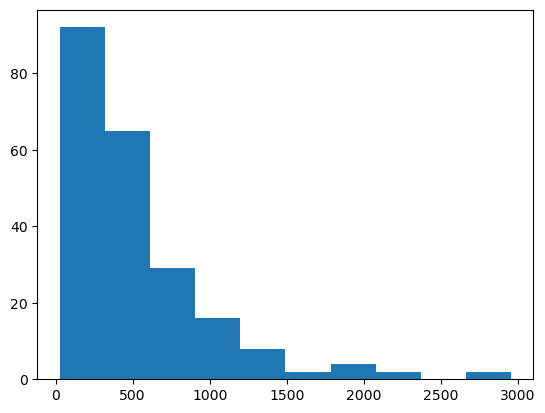

In [9]:
import matplotlib.pyplot as plt
totalNumWords = [len(one_comment.split()) for one_comment in df_data["content"]]
plt.hist(totalNumWords)
plt.show()

In [10]:
MAX_LEN = 300
bs = 16

In [11]:
device = torch.device("cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0) 

In [12]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
from keras.preprocessing.text import Tokenizer 
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_data["content"])

In [13]:
tokenized_texts = tokenizer.texts_to_sequences(df_data["content"])
# tokenized_texts = [tokenizer.tokenize(sent) for sent in df_data["content"]]
print(tokenized_texts[0])

[3331, 3332, 37, 52, 302, 517, 150, 72, 62, 59, 8, 11, 11, 13, 17, 3331, 3332, 4387, 2, 4, 23, 7, 88, 193, 105, 603, 59, 3, 890, 4, 814, 120, 20, 1, 58, 7, 120, 843, 1, 2736, 448, 5, 341, 1354, 2079, 190, 4, 198, 4, 154, 72, 23, 16, 37, 52, 302, 517, 320, 111, 4, 91, 163, 534, 76, 8, 1733, 2737, 289, 1891, 39, 1734, 449, 7, 3, 2737, 105, 244, 139, 3333, 97, 8, 481, 1355, 221, 130, 3, 2737, 7, 172, 1354, 6000, 408, 786, 1, 3334, 105, 244, 139, 481, 15, 1355, 41, 3, 128, 63, 143, 234, 5, 54, 241, 1, 145, 143, 535, 143, 159, 6, 145, 1, 78, 3335, 72, 257, 110, 4, 131, 111, 2738, 5, 2739, 6001, 3336, 202, 283, 175, 4, 290, 110, 2381, 6002, 6003, 283, 1263, 4, 290, 175, 20, 73, 67, 56, 24, 33, 83, 67, 56, 24, 33, 83, 12, 67, 56, 24, 33, 83, 12, 44, 67, 56, 24, 33, 81, 67, 56, 24, 33, 100, 54, 45, 20, 32, 34, 11, 13, 17, 3331, 3332, 4387, 47, 48, 14, 49, 14, 43, 35, 5, 2, 267, 329, 73, 73, 81, 2, 39, 1734, 2, 815, 6, 2382, 2, 891, 426, 2, 83, 12, 44, 2, 170, 1086, 2, 192, 44, 66, 8, 188, 71, 

In [14]:
input_ids = pad_sequences(tokenized_texts,
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [15]:
tags_vals = ["UNKNOWN", "Name", "Degree","Skills","College Name","Email Address","Designation","Companies worked at","Empty","Graduation Year","Years of Experience","Location"]
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [16]:
labels = cleanedDF["setences_cleaned"].tolist()

In [17]:
print(set(labels[61]))

{'Empty', 'Name', 'Companies worked at', 'UNKNOWN', 'Years of Experience', 'Designation', 'College Name', 'Degree', 'Skills'}


In [18]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["Empty"], padding="post",
                     dtype="long", truncating="post")

In [19]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [20]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [21]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [22]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [23]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))

In [24]:
#model.cuda();

In [25]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [26]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:
epochs = 5
max_grad_norm = 1.0

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        # b_input_ids, b_input_mask, b_labels = batch
        # b_input_ids = b_input_ids.to(torch.int64)
        # b_input_mask = b_input_mask.to(torch.int64)
        # b_labels = b_labels.to(torch.int64)
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/5 [00:10<?, ?it/s]


RuntimeError: expected scalar type Long but found Int